In [124]:
import pandas as pd
import numpy as np
import datetime

# models
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# tensorflow
import tensorflow as tf

# helpers
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

# plotting
import matplotlib.pyplot as plt
%matplotlib inline


# Problem 1: In which habitat does a mushroom belong?

In [114]:
# Import Datasets
mushroom_df = pd.read_csv('data/mushrooms.csv')
mushroom_df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [115]:
# Frequency distribution of habitat classes
pd.crosstab(index=mushroom_df["habitat"], columns="count")

col_0,count
habitat,
d,3148
g,2148
l,832
m,292
p,1144
u,368
w,192


In [116]:
# Create feature and target dataframes
# - apply one-hot encoding to categorical columns
# - separate the feature and target data
feature_cols = mushroom_df.columns.drop('habitat')
feature_df = pd.get_dummies(mushroom_df[feature_cols])
target_outcome = mushroom_df['habitat']

In [117]:
# Split the data into train (85%) and test (15%) sets
X_train, X_test, y_train, y_test = train_test_split(feature_df, target_outcome, test_size=0.15, random_state=42)

## Decision trees

In [118]:
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)

### Pruning using Cost Complexity

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

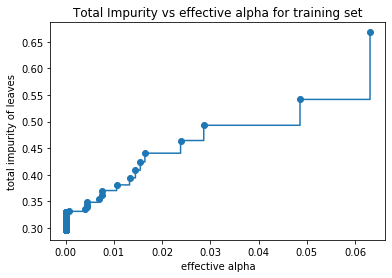

In [47]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
path = tree_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [48]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 3 with ccp_alpha: 0.07840067711701992


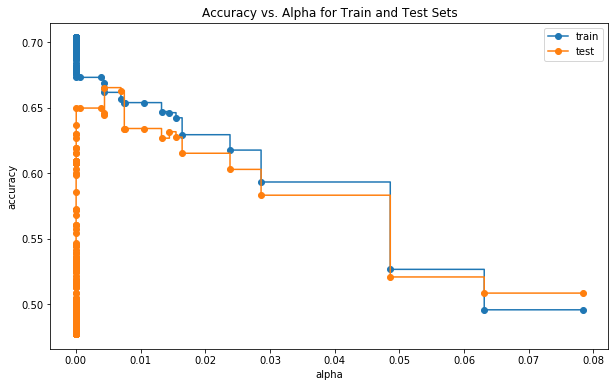

In [49]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs. Alpha for Train and Test Sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

### Feature Importances

In [35]:
feature_importances = dict(zip(feature_df.columns, tree_clf.feature_importances_))
top_fifteen = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:15]

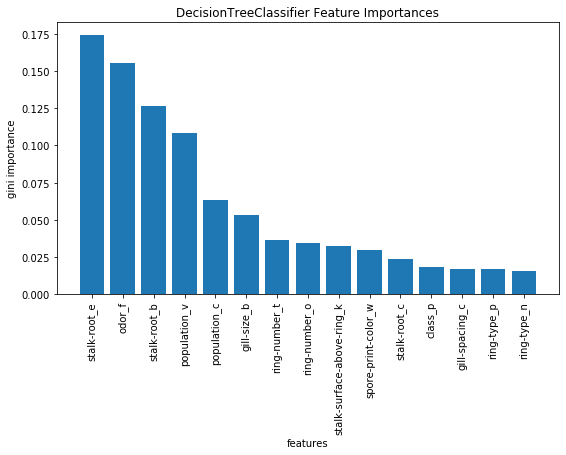

In [51]:
plt.figure(figsize=(9, 5))
plt.xlabel('features')
plt.ylabel('gini importance')
plt.title("DecisionTreeClassifier Feature Importances")
plt.bar(range(len(top_fifteen)), [f[1] for f in top_fifteen])
plt.xticks(range(len(top_fifteen)), [f[0] for f in top_fifteen], rotation=90)
plt.show()

In [54]:
top_ten_feats = [f[0] for f in top_fifteen][:12]
tree_clf_2 = tree.DecisionTreeClassifier(ccp_alpha=0.017)
tree_clf_2 = tree_clf.fit(X_train[top_ten_feats], y_train)

y_pred = tree_clf_2.predict(X_test[top_ten_feats])

### DecisionTree Graph

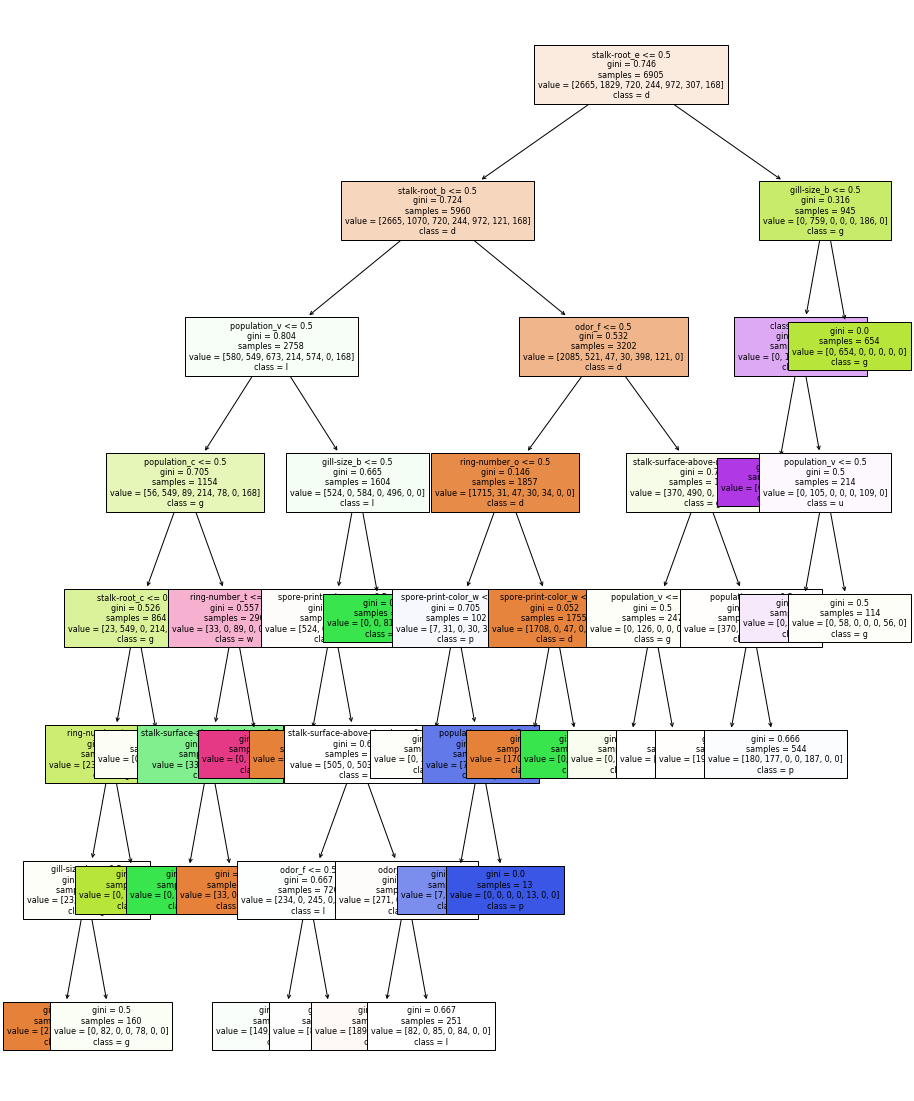

In [57]:
fig, ax = plt.subplots(figsize=(15, 20))
tree.plot_tree(tree_clf_2, ax=ax, feature_names=top_ten_feats, class_names=tree_clf_2.classes_ , fontsize=8, filled=True)
plt.show()

### Performance

In [58]:
print(classification_report(y_test, y_pred, labels=tree_clf_2.classes_, zero_division=0))

              precision    recall  f1-score   support

           d       0.78      0.78      0.78       483
           g       0.71      0.73      0.72       319
           l       0.43      0.71      0.53       112
           m       0.00      0.00      0.00        48
           p       0.31      0.26      0.28       172
           u       0.64      0.49      0.56        61
           w       1.00      1.00      1.00        24

    accuracy                           0.65      1219
   macro avg       0.55      0.57      0.55      1219
weighted avg       0.63      0.65      0.63      1219



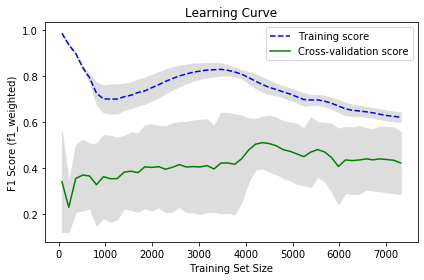

In [59]:
def plot_learning_curve(classifier, feature_df, target, scoring):
    train_sizes, train_scores, test_scores = learning_curve(classifier, 
                                                            feature_df, 
                                                            target,
                                                            cv=10,
                                                            scoring=scoring,
                                                            n_jobs=-1, 
                                                            train_sizes=np.linspace(0.01, 1.0, 50))

    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="blue",  label="Training score")
    plt.plot(train_sizes, test_mean, color="green", label="Cross-validation score")

    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("F1 Score ({})".format(scoring)), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
plot_learning_curve(tree_clf_2, feature_df, target_outcome, 'f1_weighted')

## Support Vector Machines

In [75]:
# sklearn model: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
svc_clf_rbf = SVC(kernel='rbf')
svc_clf_rbf = svc_clf_rbf.fit(X_train, y_train)

In [65]:
svc_clf_lin = SVC(kernel='linear')
svc_clf_lin = svc_clf_lin.fit(X_train, y_train)

### RBF Kernel Performance

In [70]:
y_pred = svc_clf_rbf.predict(X_test)

print(classification_report(y_test, y_pred, labels=svc_clf_rbf.classes_, zero_division=0))

              precision    recall  f1-score   support

           d       0.78      0.73      0.75       483
           g       0.69      0.71      0.70       319
           l       0.40      0.59      0.48       112
           m       0.00      0.00      0.00        48
           p       0.23      0.26      0.24       172
           u       0.58      0.52      0.55        61
           w       1.00      1.00      1.00        24

    accuracy                           0.61      1219
   macro avg       0.53      0.54      0.53      1219
weighted avg       0.61      0.61      0.61      1219



In [62]:
plot_learning_curve(svc_clf_rbf, feature_df, target_outcome, 'f1_weighted')

KeyboardInterrupt: 

### Linear Kernel Performance

In [67]:
y_pred = svc_clf_lin.predict(X_test)

print(classification_report(y_test, y_pred, labels=svc_clf_lin.classes_))

              precision    recall  f1-score   support

           d       0.74      0.77      0.76       483
           g       0.69      0.65      0.67       319
           l       0.45      0.49      0.47       112
           m       0.38      0.19      0.25        48
           p       0.27      0.30      0.28       172
           u       0.57      0.61      0.59        61
           w       1.00      1.00      1.00        24

    accuracy                           0.62      1219
   macro avg       0.59      0.57      0.57      1219
weighted avg       0.62      0.62      0.62      1219



In [68]:
plot_learning_curve(svc_clf_lin, feature_df, target_outcome, 'f1_weighted')

KeyboardInterrupt: 

### GridSearchCV

In [76]:
params_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'linear']}

In [77]:
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'kernel': ['rbf', 'linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [78]:
svc_clf_tuned = svm_model.best_estimator_
svc_clf_tuned.fit(X_train, y_train)

### Tuned Model's Performance

In [ ]:
y_pred = svc_model_tuned.predict(X_test)

print(classification_report(y_test, y_pred, labels=svc_clf_tuned.classes_))

## Boosting
* Ada boosting or gradient
* Adaboost is more about ‘voting weights’
* weak learner
* The output of the other learning algorithms ('weak learners') is combined into a weighted sum that represents the final output of the boosted classifier. AdaBoost is adaptive in the sense that subsequent weak learners are tweaked in favor of those instances misclassified by previous classifiers. AdaBoost is sensitive to noisy data and outliers.

In [127]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### GridSearchCV

In [133]:
params_grid = {'n_estimators': [50, 100, 200],  
              'learning_rate': [0.6, 0.8, 1.0],
               'loss': ['deviance', 'exponential'],
              'ccp_alpha': [0.15, 0.3, 0.5]}

In [ ]:
gb_model = GridSearchCV(GradientBoostingClassifier(), params_grid, cv=5)
gb_model.fit(X_train, y_train)

In [ ]:
gb_clf_tuned = gb_model.best_estimator_
gb_clf_tuned.fit(X_train, y_train)

### Tuned Model's Performance

In [ ]:
y_pred = gb_clf_tuned.predict(X_test)

print(classification_report(y_test, y_pred, labels=gb_clf_tuned.classes_))

# Problem 2: Is this Kiva loan for an agricultural project? 

In [82]:
# Import Datasets
kiva_df = pd.read_csv('data/kiva_loans.csv')
kiva_df.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [81]:
# Frequency distribution of sector classes
pd.crosstab(index=kiva_df["sector"], columns="count")

col_0,count
sector,
Agriculture,180302
Arts,12060
Clothing,32742
Construction,6268
Education,31013
Entertainment,830
Food,136657
Health,9223
Housing,33731


In [85]:
# Add new `days_to_fund` feature
kiva_df['days_to_fund'] = (pd.to_datetime(kiva_df.funded_time) - pd.to_datetime(kiva_df.posted_time)).dt.days
kiva_df = kiva_df[kiva_df.days_to_fund >= 0]

In [86]:
# Add new count features `female_borrowers` and `male_borrowers`

def recipient_genders(x):
    lst = x.replace(" ", "").split(',') if not pd.isna(x) else []
    return lst.count('female'), lst.count('male')

gender_counts = kiva_df.borrower_genders.apply(recipient_genders).str
kiva_df.loc[:, 'female_borrowers'] = gender_counts[0]
kiva_df.loc[:, 'male_borrowers'] = gender_counts[1]

In [88]:
# Add target feature `is_agricultural_loan` to dataframe
kiva_df['is_agricultural_loan'] = np.where(kiva_df['sector']=='Agriculture', True, False)

In [98]:
# Select a subset of features to exclude timeseries data
rel_cols = ['days_to_fund', 'funded_amount', 'loan_amount', 'term_in_months', 'repayment_interval','female_borrowers', 'male_borrowers', 'activity', 'country', 'is_agricultural_loan']
kiva_subset = kiva_df[rel_cols].copy()
kiva_subset.head()

,days_to_fund,funded_amount,loan_amount,term_in_months,repayment_interval,female_borrowers,male_borrowers,activity,country,is_agricultural_loan
0,1.0,300.0,300.0,12.0,irregular,1,0,Fruits & Vegetables,Pakistan,False
1,1.0,575.0,575.0,11.0,irregular,2,0,Rickshaw,Pakistan,False
2,0.0,150.0,150.0,43.0,bullet,1,0,Transportation,India,False
3,0.0,200.0,200.0,11.0,irregular,1,0,Embroidery,Pakistan,False
4,0.0,400.0,400.0,14.0,monthly,1,0,Milk Sales,Pakistan,False


In [99]:
# Create feature and target dataframes
# - apply one-hot encoding to categorical columns
# - separate the feature and target data
kiva_feature_cols = kiva_subset.drop(columns = ['is_agricultural_loan']).columns
kiva_features = pd.get_dummies(kiva_subset[kiva_feature_cols], prefix='', prefix_sep='')
kiva_target = kiva_subset[['is_agricultural_loan']]

In [100]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(kiva_features, kiva_target, test_size=0.20, random_state=42)

## k-nearest neighbors

In [104]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
neigh_clf = KNeighborsClassifier(n_neighbors=15)
neigh_clf.fit(X_train, np.ravel(y_train))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [106]:
y_pred = neigh_clf.predict(X_test)

### Performance (k=15)

In [107]:
print(classification_report(y_test, y_pred, labels=neigh_clf.classes_))

              precision    recall  f1-score   support

       False       0.88      0.96      0.92     91229
        True       0.85      0.63      0.72     33346

    accuracy                           0.87    124575
   macro avg       0.86      0.79      0.82    124575
weighted avg       0.87      0.87      0.86    124575



In [108]:
plot_learning_curve(neigh_clf, kiva_features, kiva_target, 'f1')

KeyboardInterrupt: 

### Performance (k=1)

In [ ]:
neigh_clf_one = KNeighborsClassifier(n_neighbors=1)
neigh_clf_one.fit(X_train, np.ravel(y_train))

In [ ]:
y_pred = neigh_clf_one.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, labels=neigh_clf_one.classes_))

In [ ]:
plot_learning_curve(neigh_clf_one, kiva_features, kiva_target, 'f1')

### Plot the F1 score as a function of k

In [117]:
# https://towardsdatascience.com/knn-using-scikit-learn-c6bed765be75
from sklearn import metrics

k_range = range(1,7)
scores = {}
scores_list = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, np.ravel(y_train))
    y_pred = knn.predict(X_test)
    scores[k] = metrics.f1_score(y_test, y_pred, average='binary')
    scores_list.append(metrics.f1_score(y_test, y_pred, average='binary'))
    

plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('F1 Score (binary)')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


KeyboardInterrupt: 

## Neural networks
* 1-2 hidden layers
* hyperparameters need to do model complexity analysis

In [50]:
# In order to reduce training times, I sampled 50,000 rows from the data
kiva_final = kiva_final.sample(n=50000, random_state=1)

In [51]:
# Split the data into train (80%) and test (20%) sets
train_dataset = kiva_final.sample(frac=0.8,random_state=0)
test_dataset = kiva_final.drop(train_dataset.index)

NameError: name 'average_precision' is not defined

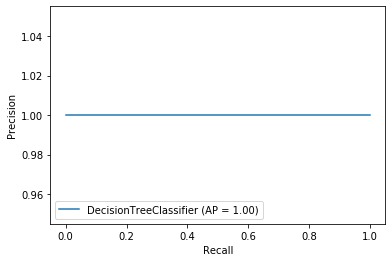

In [207]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [208]:
from sklearn.model_selection import validation_curve

# Create range of values for parameter
param_range = np.arange(1, 250, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(tree.DecisionTreeClassifier(), 
                                             onehotlabels, 
                                             mushroom_df['class'], 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Features")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

ValueError: Invalid parameter n_estimators for estimator DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'). Check the list of available parameters with `estimator.get_params().keys()`.

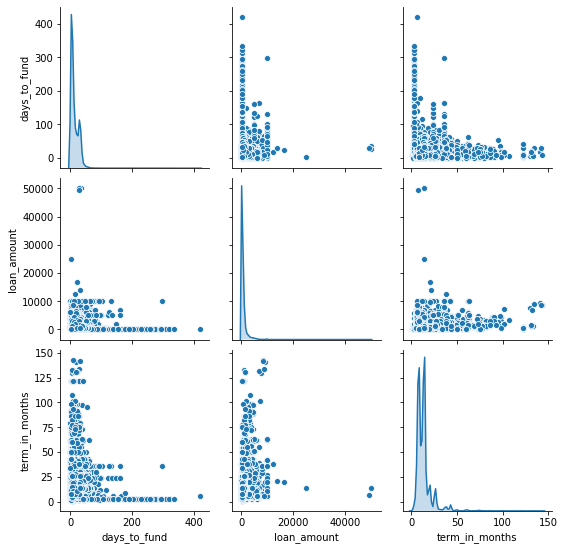

In [53]:
import seaborn as sns
sns.pairplot(kiva_final[["days_to_fund", "loan_amount", "term_in_months"]], diag_kind="kde")


In [54]:
train_stats = train_dataset.describe()
train_stats.pop("days_to_fund")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
funded_amount,40000.0,799.909375,1136.319129,25.0,250.0,475.0,900.0,50000.0
loan_amount,40000.0,799.909375,1136.319129,25.0,250.0,475.0,900.0,50000.0
term_in_months,40000.0,13.383125,8.563587,1.0,8.0,12.0,14.0,143.0
female_borrowers,40000.0,1.648550,3.134705,0.0,1.0,1.0,1.0,48.0
male_borrowers,40000.0,0.383000,1.096034,0.0,0.0,0.0,0.0,39.0
bullet,40000.0,0.096475,0.295245,0.0,0.0,0.0,0.0,1.0
irregular,40000.0,0.400425,0.489991,0.0,0.0,0.0,1.0,1.0
monthly,40000.0,0.502225,0.500001,0.0,0.0,1.0,1.0,1.0
weekly,40000.0,0.000875,0.029568,0.0,0.0,0.0,0.0,1.0
Agriculture,40000.0,0.268800,0.443341,0.0,0.0,0.0,1.0,1.0


In [55]:
train_labels = train_dataset.pop('days_to_fund')
test_labels = test_dataset.pop('days_to_fund')

In [56]:
#  

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [57]:
normed_test_data

,funded_amount,loan_amount,term_in_months,female_borrowers,male_borrowers,bullet,irregular,monthly,weekly,Agriculture,...,Entertainment,Food,Health,Housing,Manufacturing,Personal Use,Retail,Services,Transportation,Wholesale
113274,-0.395936,-0.395936,0.188808,-0.525903,0.562939,-0.326762,-0.817209,0.995547,-0.029593,1.649294,...,-0.03242,-0.510675,-0.119049,-0.224664,-0.101135,-0.24252,-0.471330,-0.263769,-0.152231,-0.030428
553422,-0.175927,-0.175927,0.072035,-0.206893,-0.349442,-0.326762,-0.817209,0.995547,-0.029593,-0.606305,...,-0.03242,-0.510675,-0.119049,-0.224664,-0.101135,-0.24252,2.121602,-0.263769,-0.152231,-0.030428
91433,-0.527941,-0.527941,-0.278286,-0.525903,0.562939,3.060253,-0.817209,-1.004447,-0.029593,1.649294,...,-0.03242,-0.510675,-0.119049,-0.224664,-0.101135,-0.24252,-0.471330,-0.263769,-0.152231,-0.030428
511600,-0.351934,-0.351934,0.188808,-0.206893,-0.349442,-0.326762,-0.817209,0.995547,-0.029593,-0.606305,...,-0.03242,1.958143,-0.119049,-0.224664,-0.101135,-0.24252,-0.471330,-0.263769,-0.152231,-0.030428
635712,-0.329933,-0.329933,0.072035,0.112116,-0.349442,-0.326762,-0.817209,0.995547,-0.029593,1.649294,...,-0.03242,-0.510675,-0.119049,-0.224664,-0.101135,-0.24252,-0.471330,-0.263769,-0.152231,-0.030428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632342,-0.593944,-0.593944,0.072035,-0.206893,-0.349442,-0.326762,-0.817209,0.995547,-0.029593,-0.606305,...,-0.03242,1.958143,-0.119049,-0.224664,-0.101135,-0.24252,-0.471330,-0.263769,-0.152231,-0.030428
176805,1.694146,1.694146,-0.862153,7.449328,-0.349442,-0.326762,1.223646,-1.004447,-0.029593,-0.606305,...,-0.03242,-0.510675,-0.119049,-0.224664,-0.101135,-0.24252,2.121602,-0.263769,-0.152231,-0.030428
649173,-0.417937,-0.417937,-0.395059,-0.206893,-0.349442,-0.326762,1.223646,-1.004447,-0.029593,-0.606305,...,-0.03242,-0.510675,-0.119049,-0.224664,-0.101135,-0.24252,-0.471330,-0.263769,-0.152231,-0.030428
596236,-0.527941,-0.527941,-0.161512,-0.206893,-0.349442,-0.326762,1.223646,-1.004447,-0.029593,1.649294,...,-0.03242,-0.510675,-0.119049,-0.224664,-0.101135,-0.24252,-0.471330,-0.263769,-0.152231,-0.030428


In [58]:
# TODO: plot the error x iterations on the train and validation sets

In [59]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [60]:
model = build_model()

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1600      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,825
Trainable params: 5,825
Non-trainable params: 0
_________________________________________________________________


In [62]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.09386683],
       [-0.26834503],
       [-0.05361506],
       [ 0.35970318],
       [ 0.09156229],
       [ 0.32175618],
       [ 0.04814667],
       [ 0.11782548],
       [-0.48411283],
       [-0.24341372]], dtype=float32)

In [95]:
# https://www.tensorflow.org/tutorials/keras/regression

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

EPOCHS = 500

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:135.6213,  mae:7.7297,  mse:135.6213,  val_loss:128.9832,  val_mae:8.1224,  val_mse:128.9832,  
....................................................................................................
Epoch: 100, loss:135.7895,  mae:7.7510,  mse:135.7896,  val_loss:127.7390,  val_mae:7.9338,  val_mse:127.7390,  
....................................................................................................
Epoch: 200, loss:136.0894,  mae:7.7522,  mse:136.0893,  val_loss:128.2605,  val_mae:7.8905,  val_mse:128.2605,  
....................................................................................................
Epoch: 300, loss:135.3306,  mae:7.7536,  mse:135.3306,  val_loss:125.2754,  val_mae:7.9781,  val_mse:125.2754,  
....................................................................................................
Epoch: 400, loss:136.3925,  mae:7.7517,  mse:136.3923,  val_loss:129.0400,  val_mae:8.0571,  val_mse:129.0400,  
................................

In [96]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,135.376638,7.738734,135.376617,130.058369,8.180460,130.058380,495
496,135.572871,7.743953,135.572815,129.356472,8.009078,129.356522,496
497,135.933757,7.726767,135.933838,134.285401,8.522965,134.285416,497
498,135.117045,7.714997,135.117065,132.196919,7.952377,132.196915,498
499,136.357103,7.740280,136.357132,128.856092,8.015110,128.856064,499


In [97]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

In [98]:
history

Text(0, 0.5, 'Days to Fund')

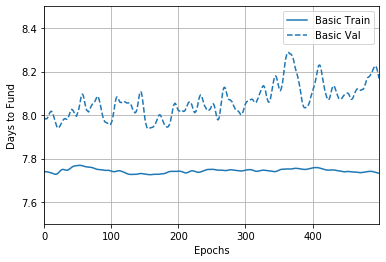

In [99]:
# mean absolute error
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([7.5, 8.5])
plt.ylabel('Days to Fund')

Text(0, 0.5, 'MSE [Days to Fund^2]')

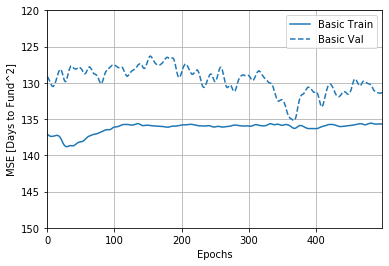

In [100]:
# mean square error
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([150, 120])
plt.ylabel('MSE [Days to Fund^2]')

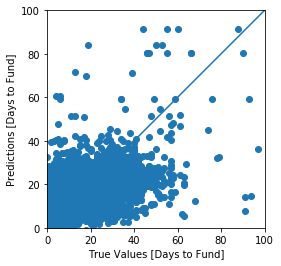

In [104]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Days to Fund]')
plt.ylabel('Predictions [Days to Fund]')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

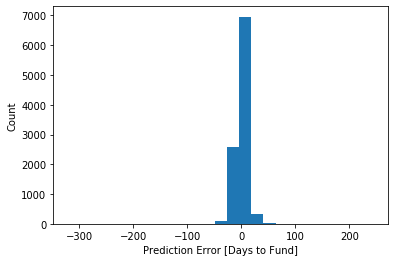

In [105]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Days to Fund]")
_ = plt.ylabel("Count")